<h1 style="margin-bottom:0"><center>DI 504: Fundementals of Deep Learning</center></h1>
<br>
<h3 style="margin-top:0"><center>Lab 3: Sequence Forecasting with LSTM and Hyperparameter Tuning</center></h2>
<h4 style="margin-top:0"><center>Given by Volga Sezen</center></h4>
<center><i>Thanks to Ayberk Aydın for the feedback.</i></center>

<center><i>

Thanks to Arif Ozan Kızıldağ.

</i></center>
<br>

-----------

In this portion of the lab we will analyze the solar cycle by looking at the number of sunspots per month. After our analysis we will use an LSTM to model the relationship between past and future cycles. 

We will delve into the LSTM architecture, as well as showcase the usage of Weights and Biases with a practical problem. Let's import our packages first.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import Tuple

import wandb

### 1) Data

The "Sunspot Index and Long-term Solar Observations" dataset has many levels of aggregation, from daily, monthly and yearly. We will focus on the monthly version, which is an average of total sunspots per day in each month.

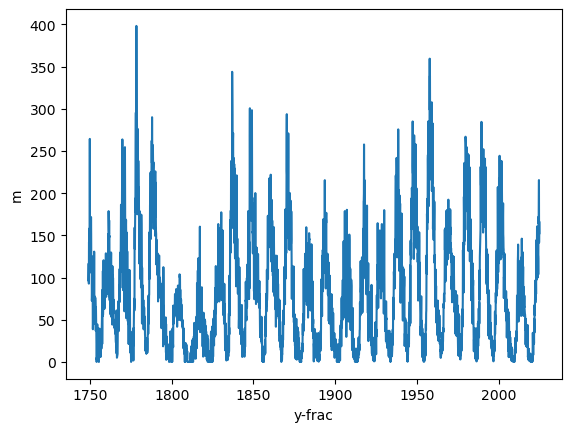

In [2]:
data = pd.read_csv('SN_m_tot_V2.0.csv', sep=';', header=None)

data.columns = ['yyyy','mm','y-frac','m','sd','n','provisional']

sns.lineplot(x="y-frac", y="m", data=data);

As you can see there is a cyclic pattern to this series, but it isn't exactly a sine wave either. Since we will solely depend on past values to predict future ones, this will be particularly challanging and our estimates will be off.

To understand the dynamics at play, let's observe the Autocorrelation and Partial Autocorrelation plots.

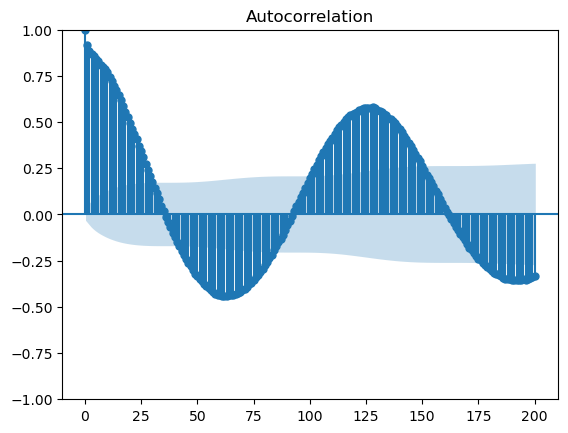

In [3]:
series = data.m.values

plot_acf(series, lags=200)
plt.show()

Autocorrelation is the correlation of a time series to itself. The x-axis is the amount of lag. At 0, we are comparing the series against itself, so the correlation is 1. Things get different when we shift the series back and measure the correlation to the original series. (i.e. how much the previous step correlates with today.)

This loosely will give us an idea about the periodicity of our signal. (There are better ways of doing this of course, like with fourier analysis.)

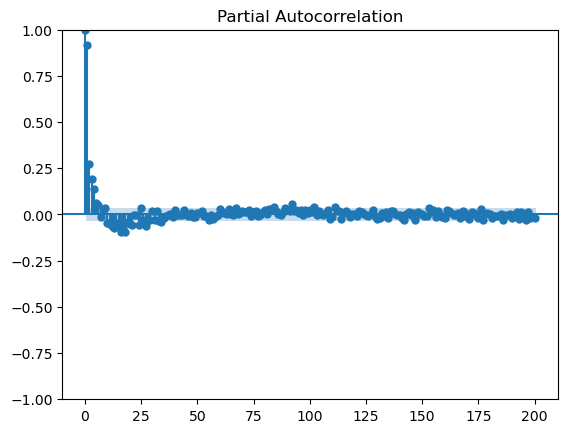

(-10.601940011701812,
 6.139120777542016e-19,
 28,
 3282,
 {'1%': -3.432344034716222,
  '5%': -2.8624210462474835,
  '10%': -2.567238999354223},
 30248.116934862534)

In [4]:
plot_pacf(series, lags=200)
plt.show()

adfuller(series)

Here we see the amount of additional "information" each lag contains. We will not focus on this part too much. Our data is stationary according to the augmented dicky fuller test, which is a good sign when it comes to time series predictions. (As an LSTM won't be too good when there is a trend in the data.)

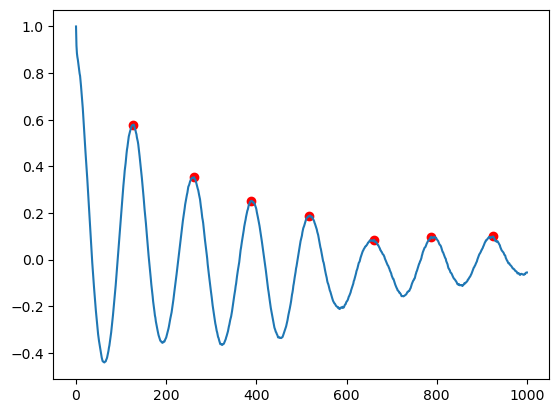

In [5]:
acf_coef = acf(series,nlags=1000)

maxima = [max(x) for x in np.array_split(acf_coef[60:],7)]

x_maxima = [np.where(x==acf_coef)[0]-1 for x in maxima]

plt.scatter(x_maxima, maxima, c='r')
plt.plot(range(1001), acf_coef)

By sliding a window, we can crudely find the local maximum along the AC function. The distance between the peaks should give us an upper limit to the number of past values that correlate with eachother.

In [6]:
np.diff(np.array(x_maxima).flatten())

array([134, 127, 129, 143, 127, 137])

We can see our dataset has a periodicity of around 132 months, or 11 years, which is approximately how long a solar cycle takes.

### 2) Create dataset for one step ahead predictions

Focusing only on the autoregressive case, we can train an LSTM model by two approaches. One involves taking n lags (previous values) as inputs to predict the next value in the sequence. This is one step ahead prediction.

An alternative approach is to predict multiple time steps ahead. Generally these types of problems are harder to solve, so we won't focus on that.

In [7]:
def split_sequences(inseq: np.array, outseq: np.array, 
                    nin: int, nout: int) -> Tuple[np.array, np.array]:
    
    X, y = list(), list()
    
    for i in range(0, len(inseq)):
        end_ix = i + nin
        out_end_idx = end_ix + nout
        
        if out_end_idx > len(inseq): break
        
        seq_x, seq_y = inseq[i:end_ix], outseq[end_ix:out_end_idx]
        
        X.append(seq_x), y.append(seq_y)

    x_t = torch.tensor(np.array(X), dtype=torch.float32)
    y_t = torch.tensor(np.array(y).flatten(), dtype=torch.float32)

    return x_t, y_t

The function above takes as input
* a series
* number of lags to consider
* number of steps to predict 

and returns both features and real values. This function is written to handle a multiple regression case as well (where features other than past lags can enter), but for now inseq and outseq will be the same time series.

With this data, we can forecast one month ahead, but what about further than that? Without training a new model, we can forecast one month, then treat our prediction as the reality to forecast the next one. This approach, of course, propoagates the errors of previous predictions.

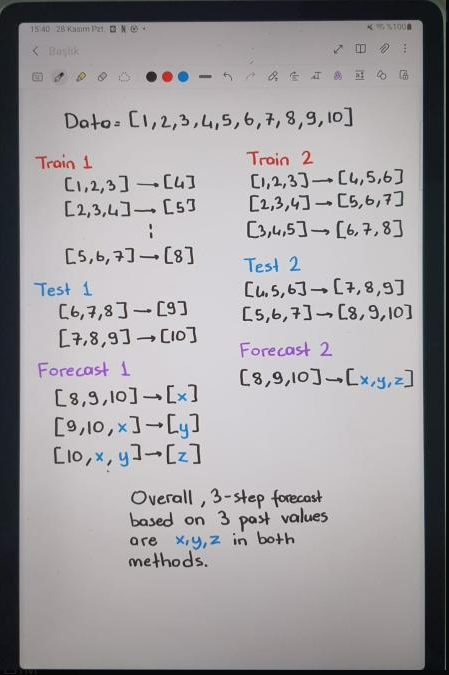

Here we've divided our time series data into 
* training (~15 cycles) 
* validation (~5 cycles) and 
* test (~5 cycles)

sets. We will use the validation set to assess performance during hyperparameter tuning, and the test set to make the final comparison.

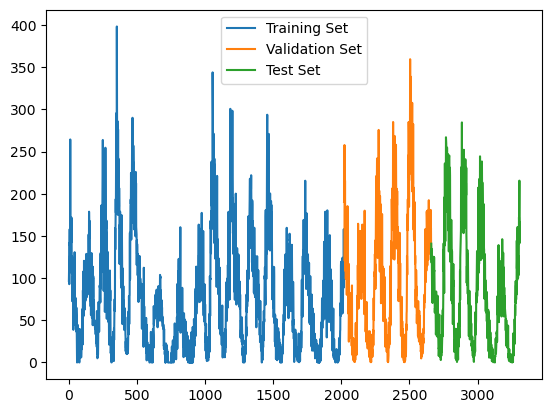

In [8]:
train = series[:2020] # ~134*15
val = series[2020:2660]
test = series[2660:]

plt.plot(range(2020),train,label='Training Set')
plt.plot(range(2020,2660),val,label='Validation Set')
plt.plot(range(2660,len(series)),test,label='Test Set')
plt.legend();

We will predict 1 value ahead given 140 lags (To be on the safe side). After splitting the features and labels, we will use the TensorDataset to create an iterable that can be passed to a DataLoader.

In [9]:
input_size, output_size = 140, 1

train_X, train_y = split_sequences(train, train, input_size ,output_size)
val_X, val_y = split_sequences(val, val, input_size, output_size)
test_X, test_y = split_sequences(test, test, input_size, output_size)

train_ds = TensorDataset(train_X, train_y)
val_ds = TensorDataset(val_X, val_y)
test_ds = TensorDataset(test_X, test_y)

### 3) LSTM model definition

LSTM (short for long-short term memory) is a model architecture built up on Recurrent Neural Networks. It is designed to capture useful representations of sequential data. LSTM networks have what is called as a cell state and hidden state. The hidden state has an internal dimension (hidden size) and as new data arrives this hidden state will be updated based on certain rules that ensures the model has memory of the past but is flexible enough for future changes.

The figure below depicts a stacked LSTM, where internal representations are used for another round of learning. At the end, either the outputs can be used, or the hidden state can be used as a feature extraction mechanism where linear layers can be attached to it. The last hidden state carries the "deepest" features, and they can be used for tasks such as time series classification, anomaly detection or even prediction. But for our prediction task, the outputs of the LSTM will be sufficient.

We covered LSTM's already, but if you want to study this area further, be sure to check out the "Sequence Models in Multimedia" course offered by Erdem hoca.

![](https://i.stack.imgur.com/QxzoG.png)

To reproduce our results we will use a combination of environment variables and seeds to control the random parts of pytorch. (The environment variable is only necessary for LSTM and GRU models.)

In [10]:
import os

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

seed = 1337

torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

class LSTM(nn.Module):
    
    def __init__(self, horizon, input_size, hidden_size, 
                 num_layers, drop, device):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=drop)
        
        self.fc =  nn.Linear(hidden_size, horizon)
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight.data, nonlinearity='relu')
        if isinstance(module, nn.LSTM):
            for w in module.all_weights[0]:
                nn.init.normal_(w)
        
    def forward(self, x):
        x = x.unsqueeze(-1)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(F.relu(out[:, -1, :]))
        return out

params = {'horizon' : 1,
          'input_size' : 1,
          'hidden_size' : 256,
          'num_layers' : 4,
          'drop' : 0,
          'device' : device}

lstm = LSTM(**params).to(device)

Couple of notes: notice how the model has an internal "init weights" method that is only called in the initiation phase. This ensures the linear and lstm layer weights follow a certain distribution once initialized. LSTM hidden states and cell states have to be manually initialized.

#### 3.1) Training helpers

Let's setup our loss function, optimiser and dataloaders.

In [11]:
n_epochs = 300
learning_rate = 0.0004623635322236683
batch_size = 32

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=False, drop_last=False)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        drop_last=False)

test_loader = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False, drop_last=False)

We've also defined simple functions to traind and evaluate our model. Note that we will use our MSE loss values as a performance metric. Though this isn't recommendable, with time series prediction you only have so many variants of metrics.

In [12]:
def training(model, optimiser, loss_fn, traindataloader, device):
    losses = 0
    model.train()
    for i, (x, y) in enumerate(traindataloader):
        optimiser.zero_grad()
        preds = model(x.to(device))
        loss = loss_fn(preds.squeeze(), y.to(device))
        loss.backward()
        optimiser.step()
        losses += loss.item()
    return losses / len(traindataloader) # loss per forecasted time unit
        
def eval(model, loss_fn, valloader, device):    
    losses = 0
    model.eval()
    for x, y in valloader:
        val_preds = model(x.to(device))
        val_loss = loss_fn(val_preds.squeeze(), y.to(device))
        losses += val_loss.item()
        
    return losses / len(valloader)

### 4) Training

In [13]:
train_losses = []
val_losses = []

train_ma = []
val_ma = []

best_val_loss = np.inf

for i in range(n_epochs):
    
    loss_t = training(lstm, optimiser, loss_fn,
                          train_loader, device)

    loss_v = eval(lstm, loss_fn, val_loader, device)

    train_ma.append(loss_t)
    val_ma.append(loss_v)

    if i%5==0:
        train_losses.append(np.mean(train_ma))
        val_losses.append(np.mean(val_ma))    
        train_ma = []
        val_ma = []
        print(f'Epoch: {i} | Train Loss: {train_losses[-1]:.5f} | Val Loss: {val_losses[-1]:.5f}', end='\r')

    if loss_v*1.05 < best_val_loss:
        # print('Overwriting new model!')
        best_val_loss = loss_v
        torch.save(lstm, "best_model.pt")

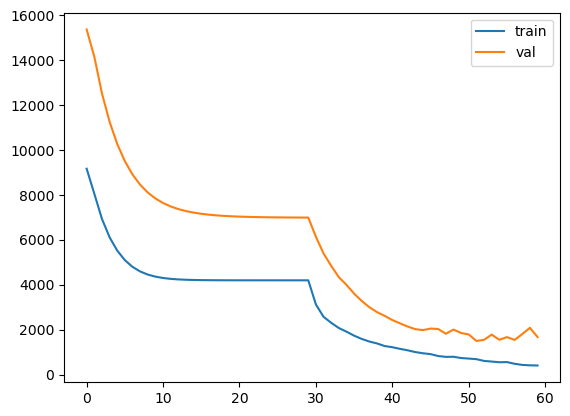

In [14]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train','val'])

After training is finished we can visualize the predictions of each month in the test set. (Remember, it takes as input values from the last 11 years up to that month.) The RMSE is about 26.

Test set RMSE: 26.2107


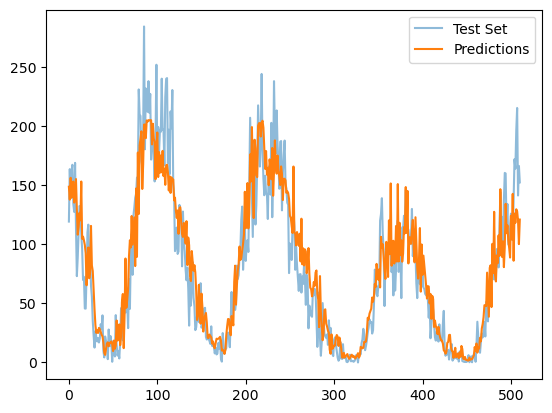

In [18]:
preds = lstm(test_X.to(device)).detach().cpu().numpy()
plt.plot(test_y,alpha=0.5, label='Test Set')
plt.plot(preds,label='Predictions')
plt.legend();

from sklearn.metrics import mean_squared_error
test_rmse = mean_squared_error(preds, test_y)**0.5
print(f'Test set RMSE: {test_rmse:.4f}')

If looked at closely, some of the higher peaks are underestimated. This includes the latest solar maximum, which is stronger than predicted by us and the scientists themselves! Of course they investigate solar dynamics with data other than past values.

To compare, let's look at the performace within the training set.

Train set RMSE: 20.3106


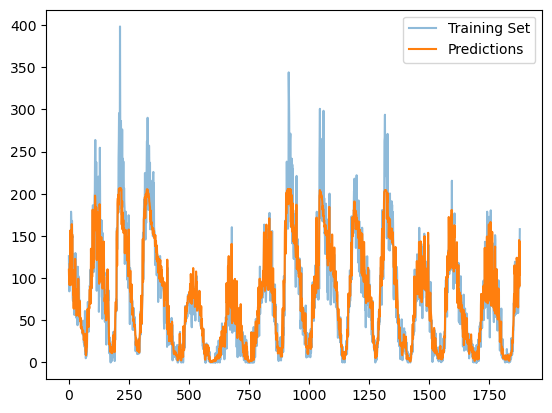

In [19]:
preds = lstm(train_X.cuda()).detach().cpu().numpy()
plt.plot(train_X[:,-1],alpha=0.5, label='Training Set')
plt.plot(preds,label='Predictions')
plt.legend();

from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(preds, train_y)**0.5
print(f'Train set RMSE: {train_rmse:.4f}')

We can see this trend continues to our training set, but the training set RMSE is higher, as expected. The validation RMSE should be in-between these two values.

### 5) W&B sweep

The above model parameters were found throuhgh a bayesian search conducted with the help of weights and biases. Let's see how this works.

Below, we define the sweep configuration dictionary that contains three keys that define
* the method
* metric and 
* parameters

1. The search method can be greedy, searching every possible combination, or one of the random ones. 

    Some foundational works have shown searching through random parameter combinations often yield very similar results to the very best solution at a fraction of the cost. But we can theoretically do even better with the bayesian search. This is more of an informed way of searching, where if previous combinations result in worse loss values, those values will be less likely to re-appear in other combinations. 

    Still, this is the ideal case. If hyperparameter combinations do not yield obvious results, this will behave more like a basic random search.

2. The metric is another dictionary with the name of the logged wandb score, and the goal. (Whether to minimize or maximise. Must for bayesian search.)

3. Finally the parameters is yet another dictionary. Inside you can set names of parameters in your model config, and values/ranges for each. When doing a random search it is a good idea to sample from certain distributions rather than assigning individual values. For simplicity, some values were handpicked.

In [ ]:
wandb.login()

sweep_config = {
    "name": "sweep_v1",
    "method": "bayes",
    "metric": {
      "name": "val_loss",
      "goal": "minimize"   
    },
    "parameters": {
        "num_layers": {
            "values": [1,2,3,4,5]
        },
        "hidden_size": {
            "values": [32,64,128,256]
        },
        "dropout": {
            "values": [0,0.05,0.1,0.2,0.3,0.4]
        },
        "learning_rate": {
            "distribution": 'log_uniform_values',
            "min": 1e-6,
            "max": 1e-3
        }
    }
}

Once we define the sweep configuration we need to create a sweep within a project. (If the project doesn't exist it will get created automatically.)

The ``run_sweep`` function will take as input a combination from the config defined above. We will access the parameter values from that config and train a model. This is all the same, except in the training loop instead of appending to a list, we will log the loss values using ``wandb.log``.

Finally we will define an agent to do this for a certain number of runs. You can also define agents in separate machines to pool their resources in searching hyperparameters in the same wandb project.

For an example project, please access it here: [https://wandb.ai/volgas/sunspot_lstm](https://wandb.ai/volgas/sunspot_lstm)

In [26]:
sweep_id = wandb.sweep(sweep_config, project="sunspot_lstm")

n_epochs = 300

def run_sweep():

    with wandb.init():
        
        config = wandb.config

        params = {'horizon' : 1,
                  'input_size' : 1,
                  'hidden_size' : config.hidden_size,
                  'num_layers' : config.num_layers,
                  'drop' : config.dropout,
                  'device' : device}

        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
        
        seed = 1337
        
        torch.manual_seed(seed)
        if device == 'cuda':
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

        lstm2 = LSTM(**params).to(device)
        
        loss_fn = torch.nn.MSELoss()
        optimiser = torch.optim.Adam(lstm2.parameters(), lr=config.learning_rate)

        val_loss = []
        train_loss = []

        for i in range(n_epochs):
            
            loss_t = training(lstm2, optimiser, loss_fn,
                                  train_loader, device)

            loss_v = eval(lstm2, loss_fn, val_loader, device)
            
            val_loss.append(loss_v)
            train_loss.append(loss_t)
            
            if i%5==0:

                wandb.log({'val_loss' : np.mean(val_loss),
                           'train_loss' : np.mean(train_loss)})

                val_loss = []
                train_loss = []

wandb.agent(sweep_id, run_sweep, count=30)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: volgas. Use `wandb login --relogin` to force relogin


Create sweep with ID: xolnhvxm
Sweep URL: https://wandb.ai/volgas/solar_activity/sweeps/xolnhvxm


wandb: Agent Starting Run: w4qmw77y with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 20
wandb: 	learning_rate: 4.3598796543157095e-05
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,4204.81966
val_loss,7365.12754


wandb: Agent Starting Run: e69x703t with config:
wandb: 	dropout: 0.4
wandb: 	hidden_size: 80
wandb: 	learning_rate: 8.404930098420926e-05
wandb: 	num_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,2492.04908
val_loss,8254.79766


wandb: Agent Starting Run: go8ypaaj with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 40
wandb: 	learning_rate: 6.244232788194319e-05
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,2820.08096
val_loss,7090.00898


wandb: Agent Starting Run: 1ysgsro5 with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 60
wandb: 	learning_rate: 4.640012131541916e-05
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,2573.10367
val_loss,7488.17725


wandb: Agent Starting Run: 4xr8wdqf with config:
wandb: 	dropout: 0.2
wandb: 	hidden_size: 40
wandb: 	learning_rate: 0.00015418849063947456
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▂▂▂▂▂▁▂▂▁▂▂▂▂▂
train_loss,2511.79771
val_loss,8214.55234


wandb: Agent Starting Run: rfflpxsg with config:
wandb: 	dropout: 0.4
wandb: 	hidden_size: 20
wandb: 	learning_rate: 2.404774226039018e-05
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
val_loss,███▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train_loss,5313.30237
val_loss,9963.86094


wandb: Agent Starting Run: yz57wy0h with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.0005303263719171456
wandb: 	num_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,███▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▂▂▅▅▄▂▂▂▂▂▄▂▂▁▂▂▄▄▄▅▅▅▆▁▄▆▅▆▆▆▄▄▃▇▅█▆▃
train_loss,2472.22643
val_loss,7033.75049


wandb: Agent Starting Run: ys7flgqk with config:
wandb: 	dropout: 0.1
wandb: 	hidden_size: 120
wandb: 	learning_rate: 9.892322996158992e-06
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,█████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train_loss,4603.47805
val_loss,8473.26562


wandb: Agent Starting Run: ny1c6ujp with config:
wandb: 	dropout: 0.2
wandb: 	hidden_size: 10
wandb: 	learning_rate: 1.6251576869797505e-06
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
val_loss,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
train_loss,10043.77495
val_loss,17062.70312


wandb: Agent Starting Run: zqplueeh with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.00064376605094634
wandb: 	num_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▄▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▁▁▄▆▆▄▃▅▄▄▆▅▃▄▄▆▇▇▅▄▅▅▆█▇▄▄▄▄▃▂▄▃▂▃▃▃▆▅
train_loss,2451.58864
val_loss,7276.68184


wandb: Agent Starting Run: il7h44dy with config:
wandb: 	dropout: 0.2
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.000633844578110436
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██████▆▄▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂▂▂▂▁▄▆▇▇█▅▃▁▆▅▄▂▂▃▃▃▄▃▄▄▄▄▂▂▃█▆▇▆▄▄▂▄
train_loss,2463.00016
val_loss,7115.7959


wandb: Agent Starting Run: eqic1jba with config:
wandb: 	dropout: 0.1
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.0004135615130941088
wandb: 	num_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▃▂▄▄▃▂▂▂▃▄▃▂▄▄▄▃▃▃▃▃▃▃▄▃▆▆▄▅▄▅▄▄▄▅▄▄▃
train_loss,2445.56527
val_loss,7445.20898


wandb: Agent Starting Run: 845pypj9 with config:
wandb: 	dropout: 0.4
wandb: 	hidden_size: 20
wandb: 	learning_rate: 0.0003833958286770645
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▂▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,2581.41726
val_loss,7743.13252


wandb: Agent Starting Run: n6k21nv9 with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 80
wandb: 	learning_rate: 0.0008776888358081052
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁
val_loss,█▁▁▁▂▂▂▂▂▂▂▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▃▃▃▂
train_loss,2888.91182
val_loss,7450.87979


wandb: Agent Starting Run: 6rnv1hrw with config:
wandb: 	dropout: 0.1
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.0009228083437641602
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁
val_loss,█▂▂▂▃▃▁▂▂▃▃▂▂▂▂▂▃▃▂▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▂▂▂▃▃▃
train_loss,3274.94843
val_loss,7026.83281


wandb: Agent Starting Run: bixihevp with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.0008350553056439116
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▃▂▂▁▁▁▁▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁
val_loss,█▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▂▂▂▁▂▁▁▂▂▁▃▂▂▂▂▂▃▃▂▂▁▂▂▂
train_loss,3388.79439
val_loss,7049.39648


wandb: Agent Starting Run: fzg2ixm5 with config:
wandb: 	dropout: 0.05
wandb: 	hidden_size: 60
wandb: 	learning_rate: 0.0008216277740431359
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they hav

train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
val_loss,█▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▃▃▃▂▂▂▂▂▂▃▃▂▂▂▃
train_loss,2931.17666
val_loss,7905.3998


wandb: Agent Starting Run: xepbcch7 with config:
wandb: 	dropout: 0.4
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.0008696256937777325
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▅▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,2544.92788
val_loss,8434.31816


wandb: Agent Starting Run: ut9hgvo0 with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.0009051035631297572
wandb: 	num_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_loss,▂▂▁▄▆▆▅▅▅▇▆▇▅▆▅▅▆▆▆▆▇▅▅▆█▇▅▃▅▅▄▄▄▄▅▅▄▅▃▃
train_loss,2439.38404
val_loss,7098.37148


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0n0ix4l with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 120
wandb: 	learning_rate: 6.453174531767224e-05
wandb: 	num_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▆▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,2449.00598
val_loss,7770.74687


wandb: Agent Starting Run: m2tvff1x with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 120
wandb: 	learning_rate: 6.496651413055965e-05
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3452.85048
val_loss,6735.41152


wandb: Agent Starting Run: bpyy6omn with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 120
wandb: 	learning_rate: 5.369540089820638e-05
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▆▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3491.83452
val_loss,6866.58135


wandb: Agent Starting Run: 2bt1jvcf with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.00018618572369115348
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▂▂▂▂▂▂▂▁▂▁▁▁▂▂▂▁▂▁▂▂▁▁▁▂▂▁▁▂▁▂▁▂▂▁
train_loss,2445.01403
val_loss,7470.02275


wandb: Agent Starting Run: 4yj0im6e with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 80
wandb: 	learning_rate: 0.00013356011618192426
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3429.11417
val_loss,7252.08691


wandb: Agent Starting Run: hn7vwf53 with config:
wandb: 	dropout: 0.05
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.0001664773870983514
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they hav

train_loss,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3451.22973
val_loss,6819.71729


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ta1qocv2 with config:
wandb: 	dropout: 0.1
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.0002810291606599299
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3393.35142
val_loss,7005.94336


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jzut3lfu with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.00010480743182848846
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3381.37262
val_loss,6885.42734


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cwi8qlvl with config:
wandb: 	dropout: 0.05
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.00029942403295154385
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they hav

train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3441.4255
val_loss,6790.94482


wandb: Agent Starting Run: jd3hxd03 with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 120
wandb: 	learning_rate: 8.940195904860787e-05
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3418.27548
val_loss,6694.20137


wandb: Agent Starting Run: hbi7og6w with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.0005281160811694544
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
train_loss,3101.36804
val_loss,7321.67471


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: puzs6719 with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.00025485595420712457
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▇▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3191.82773
val_loss,6773.8999


wandb: Agent Starting Run: fnvikilk with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 10
wandb: 	learning_rate: 5.430311948054584e-05
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,███████▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,████████▇▇▇▇▇▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
train_loss,4314.91355
val_loss,7989.36855


wandb: Agent Starting Run: ap1i0jgf with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 20
wandb: 	learning_rate: 0.00024674777338361845
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train_loss,3147.51695
val_loss,6846.11162


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0l03nj62 with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 40
wandb: 	learning_rate: 0.00018731616982389055
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,2856.54078
val_loss,7795.97041


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a50bk4aj with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 60
wandb: 	learning_rate: 0.0008405877542586385
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▇▆▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▁▁▂▅▃▆▄▅▆▇▆▇▇█▆▆▇▆▆▇▅▅▃▄▄▅▅▄▅▅▅▅▃▄▃▅▄▅▇
train_loss,2521.6732
val_loss,7871.82256


wandb: Agent Starting Run: 4y8vvu0d with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 20
wandb: 	learning_rate: 0.0001556534769129984
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▇▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3164.22388
val_loss,6799.14014


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xlhewbha with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 20
wandb: 	learning_rate: 0.0001435464053960619
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▇▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3202.25063
val_loss,6869.01406


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nxc1jfht with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.0002133107456744512
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▇▆▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3257.96319
val_loss,6606.80254


wandb: Agent Starting Run: 6vzexh2w with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.0001904688546893654
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,██▇▇▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▇▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3244.16192
val_loss,6727.52588


wandb: Agent Starting Run: 7n2smqxl with config:
wandb: 	dropout: 0.05
wandb: 	hidden_size: 120
wandb: 	learning_rate: 0.0003579314363512363
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they hav

train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3393.51427
val_loss,6931.7168


wandb: Agent Starting Run: 363dikcg with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.0009689152230338446
wandb: 	num_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▄▃▃▃▃▃▃▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,2535.84704
val_loss,7196.41533


wandb: Agent Starting Run: ahyiopsb with config:
wandb: 	dropout: 0
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.0006646380970376524
wandb: 	num_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect re

train_loss,█▇▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▂▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,2640.02029
val_loss,7998.49687


wandb: Agent Starting Run: 7mrchwm4 with config:
wandb: 	dropout: 0.1
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.0004157580561799015
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,██▄▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3111.36554
val_loss,6749.20166


wandb: Agent Starting Run: 3330nx7b with config:
wandb: 	dropout: 0.2
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.00022434262677911032
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,██▇▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3184.06411
val_loss,6757.54951


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tzrbzr98 with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.00032290933481371014
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,██▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3133.74585
val_loss,6891.18193


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h8o4kd0k with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.0004396473306115305
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3027.80587
val_loss,7202.68809


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4pt3ipov with config:
wandb: 	dropout: 0.4
wandb: 	hidden_size: 10
wandb: 	learning_rate: 6.306487834086019e-05
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,███████▇▇▇▇▇▆▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,███████▇▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,4028.04593
val_loss,7569.26533


wandb: Agent Starting Run: 78bf50q8 with config:
wandb: 	dropout: 0.2
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.00039193258700808504
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,██▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3162.21185
val_loss,6918.86289


wandb: Agent Starting Run: 2wstciwl with config:
wandb: 	dropout: 0.2
wandb: 	hidden_size: 20
wandb: 	learning_rate: 0.00021391455377013023
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,██▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3223.64676
val_loss,6941.11816


wandb: Agent Starting Run: wv5npn17 with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.00018551513627063527
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,███▇▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▇▆▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3263.83777
val_loss,6613.48711


wandb: Agent Starting Run: drc97dsa with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.0001298857400790968
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,███▇▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3360.14533
val_loss,6662.35078


wandb: Agent Starting Run: zlyhqfj8 with config:
wandb: 	dropout: 0.1
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.00032743963218390327
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,██▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3139.75981
val_loss,6842.57109


wandb: Agent Starting Run: j5o8zha3 with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 10
wandb: 	learning_rate: 9.885517623857576e-05
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,████▇▇▇▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3590.94394
val_loss,6756.70459


wandb: Agent Starting Run: i1wcqgf2 with config:
wandb: 	dropout: 0.2
wandb: 	hidden_size: 10
wandb: 	learning_rate: 9.256800305090584e-05
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,█████▇▇▇▆▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3636.49932
val_loss,6707.46631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a5x2dlc4 with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 40
wandb: 	learning_rate: 0.0002025700854029882
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,█▆▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
train_loss,3054.70701
val_loss,7308.62363


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5l90braa with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 10
wandb: 	learning_rate: 7.889964480064066e-05
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,█████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██████▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3768.75051
val_loss,7051.78438


wandb: Agent Starting Run: 6b60158r with config:
wandb: 	dropout: 0.2
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.00012325342965226996
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,████▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3417.20187
val_loss,6523.19727


wandb: Agent Starting Run: 3lbn3fqp with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 20
wandb: 	learning_rate: 0.0002162308752544073
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,██▆▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3198.4866
val_loss,6929.52861


wandb: Agent Starting Run: b5lu5hd4 with config:
wandb: 	dropout: 0.3
wandb: 	hidden_size: 20
wandb: 	learning_rate: 0.00026756698307964883
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,██▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▂▂
train_loss,2814.19252
val_loss,7347.75557


wandb: Agent Starting Run: 52w4lbwo with config:
wandb: 	dropout: 0.2
wandb: 	hidden_size: 10
wandb: 	learning_rate: 0.000805382754391706
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

train_loss,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,2931.67057
val_loss,7945.5001
